In [192]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import r2_score

from sklearn.preprocessing import LabelEncoder

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [5]:
homes = pd.read_csv('homes_final.csv')
homes

Unnamed: 0  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape  \
0              1          60       RL           65     8450   Pave      Reg   
1              2          20       RL           80     9600   Pave      Reg   
2              3          60       RL           68    11250   Pave      IR1   
3              4          70       RL           60     9550   Pave      IR1   
4              5          60       RL           84    14260   Pave      IR1   
...          ...         ...      ...          ...      ...    ...      ...   
1455        1456          60       RL           62     7917   Pave      Reg   
1456        1457          20       RL           85    13175   Pave      Reg   
1457        1458          70       RL           66     9042   Pave      Reg   
1458        1459          20       RL           68     9717   Pave      Reg   
1459        1460          20       RL           75     9937   Pave      Reg   

     LandContour Utilities LotConfig  ... OpenPorchSF EnclosedPorch  \
0            Lvl    AllPub    Inside  ...          61             0   
1            Lvl    AllPub       FR2  ...           0             0   
2            Lvl    AllPub    Inside  ...          42             0   
3            Lvl    AllPub    Corner  ...          35           272   
4            Lvl    AllPub       FR2  ...          84             0   
...          ...       ...       ...  ...         ...           ...   
1455         Lvl    AllPub    Inside  ...          40             0   
1456         Lvl    AllPub    Inside  ...           0             0   
1457         Lvl    AllPub    Inside  ...          60             0   
1458         Lvl    AllPub    Inside  ...           0           112   
1459         Lvl    AllPub    Inside  ...          68             0   

     X3SsnPorch ScreenPorch MiscVal MoSold  YrSold  SaleType  SaleCondition  \
0             0           0       0      2    2008        WD         Normal   
1             0           0       0      5    2007        WD         Normal   
2             0           0       0      9    2008        WD         Normal   
3             0           0       0      2    2006        WD        Abnorml   
4             0           0       0     12    2008        WD         Normal   
...         ...         ...     ...    ...     ...       ...            ...   
1455          0           0       0      8    2007        WD         Normal   
1456          0           0       0      2    2010        WD         Normal   
1457          0           0    2500      5    2010        WD         Normal   
1458          0           0       0      4    2010        WD         Normal   
1459          0           0       0      6    2008        WD         Normal   

      SalePrice  
0        208500  
1        181500  
2        223500  
3        140000  
4        250000  
...         ...  
1455     175000  
1456     210000  
1457     266500  
1458     142125  
1459     147500  

[1460 rows x 75 columns]

In [108]:
X = homes.copy().drop(['SalePrice', 'Unnamed: 0'], axis = 1)
y = np.log(homes.copy()['SalePrice'])

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
lencoder = LabelEncoder()

In [27]:
def numer_label(DF):
    '''
    Assign numeric labels to values in non-numeric columns.
    To prepare data for gradient boosting regressor.
    '''
    categ_cols = list(filter(lambda name: DF[name].dtype == 'O', DF.columns))
    for name in categ_cols:
        DF[name] = lencoder.fit_transform(DF[name])
    return DF

In [115]:
X_train_gbr = numer_label(X_train.copy())
X_test_gbr = numer_label(X_test.copy())

In [116]:
gbr = GradientBoostingRegressor()

gb_params = {'n_estimators': [500, 1000, 1500, 2000],
             'learning_rate': 10**np.linspace(-3,0,4),
             'max_depth': [1, 2, 3]}

gs = GridSearchCV(gbr, gb_params, scoring = 'r2', cv = 5)

gs.fit(X_train_gbr, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': array([0.001, 0.01 , 0.1  , 1.   ]),
                         'max_depth': [1, 2, 3],
                         'n_estimators': [500, 1000, 1500, 2000]},
             scoring='r2')

In [117]:
gbr_best = GradientBoostingRegressor(n_estimators=1000)

In [118]:
print(gbr_best.score(X_train_gbr, y_train))
print(gbr_best.score(X_test_gbr, y_test)) #best model from cross-validation yields severe overfitting

0.9983828607801926
0.8400422844582863


In [119]:
# Plotting train/test score for various learning_rates and max_depths n_estimator=500

learning_rates = 10**np.linspace(-3, 0, 20)
train_scores = []
test_scores = []
gbr = GradientBoostingRegressor()
for rate in learning_rates:
    gbr.set_params(n_estimators = 500, learning_rate = rate, max_depth = 1)
    gbr.fit(X_train_gbr, y_train)
    train_scores.append(gbr.score(X_train_gbr, y_train))
    test_scores.append(gbr.score(X_test_gbr, y_test))
    
pd.DataFrame({'learning_rate': learning_rates, 'train_scores': train_scores, 'test_scores': test_scores})

learning_rate  train_scores  test_scores
0        0.001000      0.299161     0.281779
1        0.001438      0.380530     0.360382
2        0.002069      0.471557     0.448409
3        0.002976      0.565999     0.539805
4        0.004281      0.654390     0.626527
5        0.006158      0.730837     0.701716
6        0.008859      0.792461     0.763520
7        0.012743      0.838728     0.815785
8        0.018330      0.870846     0.845682
9        0.026367      0.892726     0.863843
10       0.037927      0.908826     0.876917
11       0.054556      0.921074     0.877236
12       0.078476      0.928371     0.881796
13       0.112884      0.936198     0.877098
14       0.162378      0.941343     0.878148
15       0.233572      0.946415     0.865645
16       0.335982      0.950708     0.830907
17       0.483293      0.955430     0.543796
18       0.695193      0.960048     0.832015
19       1.000000      0.965756     0.804344

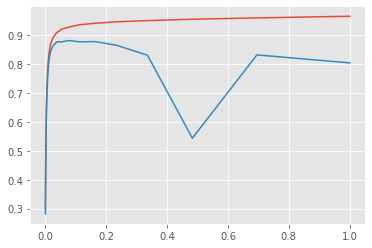

In [120]:
plt.plot(learning_rates, train_scores)
plt.plot(learning_rates, test_scores)

In [121]:
learning_rates = 10**np.linspace(-3, 0, 20)
train_scores = []
test_scores = []
gbr = GradientBoostingRegressor()
for rate in learning_rates:
    gbr.set_params(n_estimators = 500, learning_rate = rate, max_depth = 2)
    gbr.fit(X_train_gbr, y_train)
    train_scores.append(gbr.score(X_train_gbr, y_train))
    test_scores.append(gbr.score(X_test_gbr, y_test))
    
pd.DataFrame({'learning_rate': learning_rates, 'train_scores': train_scores, 'test_scores': test_scores})

learning_rate  train_scores  test_scores
0        0.001000      0.406664     0.387537
1        0.001438      0.511244     0.487147
2        0.002069      0.618514     0.591439
3        0.002976      0.715963     0.687176
4        0.004281      0.794424     0.769694
5        0.006158      0.850070     0.825981
6        0.008859      0.887888     0.859990
7        0.012743      0.913394     0.878926
8        0.018330      0.931657     0.886344
9        0.026367      0.943135     0.885438
10       0.037927      0.951487     0.881734
11       0.054556      0.960006     0.875935
12       0.078476      0.967322     0.866585
13       0.112884      0.975339     0.855046
14       0.162378      0.982110     0.824270
15       0.233572      0.988468     0.833786
16       0.335982      0.993845     0.821603
17       0.483293      0.997106     0.541820
18       0.695193      0.998526     0.810838
19       1.000000      0.999343     0.793592

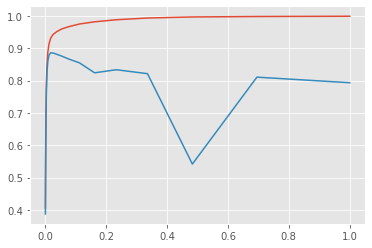

In [122]:
plt.plot(learning_rates, train_scores)
plt.plot(learning_rates, test_scores)

In [123]:
learning_rates = 10**np.linspace(-3, 0, 20)
train_scores = []
test_scores = []
gbr = GradientBoostingRegressor()
for rate in learning_rates:
    gbr.set_params(n_estimators = 500, learning_rate = rate, max_depth = 3)
    gbr.fit(X_train_gbr, y_train)
    train_scores.append(gbr.score(X_train_gbr, y_train))
    test_scores.append(gbr.score(X_test_gbr, y_test))
    
pd.DataFrame({'learning_rate': learning_rates, 'train_scores': train_scores, 'test_scores': test_scores})

learning_rate  train_scores  test_scores
0        0.001000      0.466783     0.440437
1        0.001438      0.579661     0.549209
2        0.002069      0.692068     0.658240
3        0.002976      0.787330     0.751716
4        0.004281      0.858842     0.821937
5        0.006158      0.904637     0.867495
6        0.008859      0.931224     0.888033
7        0.012743      0.948386     0.894993
8        0.018330      0.960179     0.889178
9        0.026367      0.968746     0.876240
10       0.037927      0.976021     0.868467
11       0.054556      0.983213     0.861072
12       0.078476      0.988764     0.855924
13       0.112884      0.994088     0.867184
14       0.162378      0.997267     0.841467
15       0.233572      0.999077     0.780731
16       0.335982      0.999769     0.856160
17       0.483293      0.999966     0.722634
18       0.695193      0.999997     0.768853
19       1.000000      1.000000     0.350207

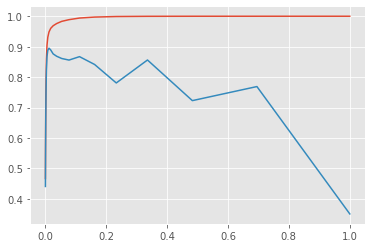

In [124]:
plt.plot(learning_rates, train_scores)
plt.plot(learning_rates, test_scores)

In [133]:
# Get good balance between test/train score at learning_rate = 0.037927, max_depth = 1

gbr.set_params(n_estimators = 500, learning_rate = 0.037927, max_depth = 1)

GradientBoostingRegressor(learning_rate=0.037927, max_depth=1, n_estimators=500)

In [191]:
# Feature importances 

sorted(list(zip(X_train_gbr.columns, gbr.feature_importances_)), key = lambda x: -x[1])

[('OverallQual', 0.5630903816833007),
 ('GrLivArea', 0.1367042475194275),
 ('TotalBsmtSF', 0.050941770258901516),
 ('CentralAir', 0.028356006487864543),
 ('BsmtFinSF1', 0.02341676746019219),
 ('LotArea', 0.023390115075020045),
 ('GarageCars', 0.02025543928966084),
 ('X1stFlrSF', 0.016138740399424256),
 ('GarageArea', 0.013411763523542989),
 ('YearRemodAdd', 0.010619822021695466),
 ('YearBuilt', 0.009678757930284986),
 ('LotFrontage', 0.007869721155216924),
 ('Neighborhood', 0.0074544265459815275),
 ('BsmtUnfSF', 0.006420225566737275),
 ('MoSold', 0.005902676667514271),
 ('OverallCond', 0.005735258522620031),
 ('OpenPorchSF', 0.005646420866709839),
 ('BsmtExposure', 0.004948871704524023),
 ('MasVnrArea', 0.004174382438034297),
 ('Functional', 0.0037751661869940677),
 ('HouseStyle', 0.003266480813601731),
 ('TotRmsAbvGrd', 0.003264658819777934),
 ('WoodDeckSF', 0.0027187502440389876),
 ('BsmtQual', 0.0027124835641009182),
 ('GarageType', 0.0027060981154375372),
 ('BsmtFinType1', 0.002624

In [126]:
test_data = pd.read_csv('test_final.csv').drop('Unnamed: 0', axis = 1)
test_data = numer_label(test_data)
test_data

MSSubClass  MSZoning  LotFrontage  LotArea  Street  LotShape  \
0             20         2           80    11622       1         3   
1             20         3           81    14267       1         0   
2             60         3           74    13830       1         0   
3             60         3           78     9978       1         0   
4            120         3           43     5005       1         0   
...          ...       ...          ...      ...     ...       ...   
1454         160         4           21     1936       1         3   
1455         160         4           21     1894       1         3   
1456          20         3          160    20000       1         3   
1457          85         3           62    10441       1         3   
1458          60         3           74     9627       1         3   

      LandContour  Utilities  LotConfig  LandSlope  ...  WoodDeckSF  \
0               3          0          4          0  ...         140   
1               3          0          0          0  ...         393   
2               3          0          4          0  ...         212   
3               3          0          4          0  ...         360   
4               1          0          4          0  ...           0   
...           ...        ...        ...        ...  ...         ...   
1454            3          0          4          0  ...           0   
1455            3          0          4          0  ...           0   
1456            3          0          4          0  ...         474   
1457            3          0          4          0  ...          80   
1458            3          0          4          1  ...         190   

      OpenPorchSF  EnclosedPorch  X3SsnPorch  ScreenPorch  MiscVal  MoSold  \
0               0              0           0          120        0       6   
1              36              0           0            0    12500       6   
2              34              0           0            0        0       3   
3              36              0           0            0        0       6   
4              82              0           0          144        0       1   
...           ...            ...         ...          ...      ...     ...   
1454            0              0           0            0        0       6   
1455           24              0           0            0        0       4   
1456            0              0           0            0        0       9   
1457           32              0           0            0      700       7   
1458           48              0           0            0        0      11   

      YrSold  SaleType  SaleCondition  
0       2010         8              4  
1       2010         8              4  
2       2010         8              4  
3       2010         8              4  
4       2010         8              4  
...      ...       ...            ...  
1454    2006         8              4  
1455    2006         8              0  
1456    2006         8              0  
1457    2006         8              4  
1458    2006         8              4  

[1459 rows x 73 columns]

In [134]:
predictions = pd.DataFrame({'Id': np.arange(1461, 2920), 'SalePrice': np.e**gbr.predict(test_data)})
predictions.to_csv('predictions.csv', index = False)
# get Kaggle score of 0.28833 (position 3793)

Id      SalePrice
0     1461  165981.996685
1     1462  166683.004089
2     1463  167055.552750
3     1464  167798.031070
4     1465  166170.870043
...    ...            ...
1454  2915  161841.022237
1455  2916  161885.581122
1456  2917  167302.094057
1457  2918  164136.768304
1458  2919  166953.477468

[1459 rows x 2 columns]

ELASTIC NET REGRESSION:

In [156]:
X_dum = pd.get_dummies(X)
X_train_dum, X_test_dum, y_train, y_test = train_test_split(X_dum, y, test_size=0.2, random_state=42)

In [157]:
# Cross-validation for elastic net regression

param_grid = {'alpha': np.linspace(.0001, .0101, 101), 'l1_ratio': np.linspace(.01, 1, 100)}
enet = ElasticNet(normalize = True, max_iter = 100000)
gs2 = GridSearchCV(estimator = enet, param_grid = param_grid, cv = 5, scoring = 'r2')
gs2.fit(X_train_dum, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(max_iter=100000, normalize=True),
             param_grid={'alpha': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016,
       0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023, 0.0024,
       0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003 , 0.0031, 0.0032,
       0.0033, 0.0034, 0.0035, 0.0036, 0.0...
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])},
             scoring='r2')

In [159]:
enet_best = gs2.best_estimator_
enet_best

ElasticNet(alpha=0.0005, l1_ratio=0.06999999999999999, max_iter=100000,
           normalize=True)

In [160]:
print(enet_best.score(X_train_dum, y_train))
print(enet_best.score(X_test_dum, y_test))

0.9204854446594319
0.9042343968482067


In [167]:
test_data = pd.read_csv('test_final.csv').drop('Unnamed: 0', axis = 1)
test_data = pd.get_dummies(test_data)
test_data # problem: fewer columns in dummified test_data
          # refit lasso regression using only columns that appear in test_data

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=267)

In [174]:
test_cols = list(filter(lambda x: x in test_data.columns, X_train_dum.columns))

param_grid = {'alpha': np.linspace(.0001, .0101, 101), 'l1_ratio': np.linspace(.01, 1, 100)}
enet = ElasticNet(normalize = True, max_iter = 100000)
gs3 = GridSearchCV(estimator = enet, param_grid = param_grid, cv = 5, scoring = 'r2')
gs3.fit(X_train_dum[test_cols], y_train)

GridSearchCV(cv=5, estimator=ElasticNet(max_iter=100000, normalize=True),
             param_grid={'alpha': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016,
       0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023, 0.0024,
       0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003 , 0.0031, 0.0032,
       0.0033, 0.0034, 0.0035, 0.0036, 0.0...
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])},
             scoring='r2')

In [221]:
enet_best = gs3.best_estimator_
# heavily weighted toward ridge error term

ElasticNet(alpha=0.0005, l1_ratio=0.09, max_iter=100000, normalize=True)

In [186]:
print(enet_best.score(X_train_dum[test_cols], y_train))
print(enet_best.score(X_test_dum[test_cols], y_test))

# No evidence of overfitting

0.9076400304898021
0.8994205063507905


In [184]:
np.e**enet_best.predict(test_data)

array([119639.92289783, 150266.17483862, 178185.52993232, ...,
       162140.24731615, 115527.22713098, 218659.61569295])

In [187]:
predictions_enet = pd.DataFrame({'Id': np.arange(1461, 2920), 'SalePrice': np.e**enet_best.predict(test_data)})
predictions_enet.to_csv('predictions_enet.csv', index = False) 
# Kaggle score improved to 0.14417 (position 2281)

In [210]:
# another elastic net regression, using only predictors with VIF < 10

AC = add_constant(X_train_dum[test_cols])
VIFs = pd.Series([variance_inflation_factor(AC.values, i) for i in range(AC.shape[1])], index=AC.columns)
VIFs = VIFs.sort_values()
VIFs = VIFs[(VIFs.index != 'const') & (VIFs < 10)]

In [213]:
VIF_cols = VIFs.index

In [217]:
param_grid = {'alpha': np.linspace(.0001, .0101, 101), 'l1_ratio': np.linspace(.01, 1, 100)}
enet = ElasticNet(normalize = True, max_iter = 100000)
gs4 = GridSearchCV(estimator = enet, param_grid = param_grid, cv = 5, scoring = 'r2')
gs4.fit(X_train_dum[VIF_cols], y_train)

GridSearchCV(cv=5, estimator=ElasticNet(max_iter=100000, normalize=True),
             param_grid={'alpha': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016,
       0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023, 0.0024,
       0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003 , 0.0031, 0.0032,
       0.0033, 0.0034, 0.0035, 0.0036, 0.0...
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])},
             scoring='r2')

In [325]:
vif_best = gs.best_estimator_
vif_best

# heavily weighted toward lasso error term

ElasticNet(alpha=0.0001, l1_ratio=0.54, max_iter=100000, normalize=True)

In [220]:
print(vif_best.score(X_train_dum[VIF_cols], y_train))
print(vif_best.score(X_test_dum[VIF_cols], y_test))

# Still no evidence of overfitting, but lower accuracy

0.8340654555274385
0.8329987102488527


In [222]:
predictions_vif = pd.DataFrame({'Id': np.arange(1461, 2920),
                                'SalePrice': np.e**vif_best.predict(test_data[VIF_cols])})
predictions_vif.to_csv('predictions_vif.csv', index = False)
# Slighly worse result than before: Kaggle score of 0.17528

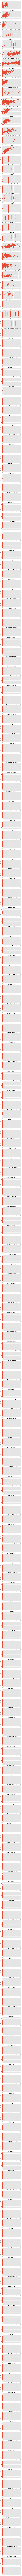

In [224]:
# Examining scatterplots of each predictor against target

X_partial = X_train_dum[test_cols]

fig, axs = plt.subplots(X_partial.columns.shape[0], figsize = (6, 800))
for i in range(X_partial.columns.shape[0]):
    axs[i].scatter(x = X_partial[X_partial.columns[i]], y = y_train)
    axs[i].set_title(X_partial.columns[i])

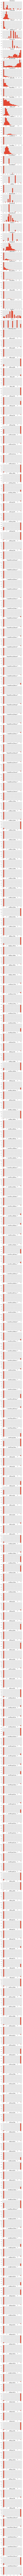

In [244]:
# Examining distribution of each predictor

fig, axs = plt.subplots(X_partial.columns.shape[0], figsize = (6, 800))
for i in range(X_partial.columns.shape[0]):
    axs[i].hist(x = X_partial[X_partial.columns[i]], bins = 20)
    axs[i].set_title(X_partial.columns[i])

In [254]:
# Manually selecting columns that display an approximately linear relationship with predictor
# or an approximately normal distribution (up to transformation)

X_manual_cols = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
                   'TotalBsmtSF', 'GrLivArea', 'BedroomAbvGr', 'TotRmsAbvGrd',
                   'GarageCars', 'GarageArea', 'FullBath', 'Fireplaces', 'MoSold', 'LotShape_Reg',
                   'LotConfig_Inside', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
                   'HouseStyle_1Story', 'HouseStyle_2Story', 'RoofStyle_Gable', 'RoofStyle_Hip',
                   'MasVnrType_Stone', 'ExterQual_Ex', 'ExterQual_Fa', 'Foundation_PConc',
                   'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_None', 'BsmtExposure_None',
                   'HeatingQC_Ex', 'HeatingQC_Fa', 'CentralAir_N', 'CentralAir_Y',
                   'KitchenQual_Ex', 'GarageType_None']

In [256]:
def transform(DF):
    '''
    Restrict data frame to X_manual_cols
    '''
    DF = DF[X_manual_cols].copy()
    DF['LotFrontage'] = DF['LotFrontage']**.5
    DF['LotArea'] = np.log(DF['LotFrontage'])
    DF['TotalBsmtSF'] = DF['TotalBsmtSF']**.5
    DF['GrLivArea'] = np.log(DF['GrLivArea'])
    
    return DF

In [262]:
X_manual = transform(X_train_dum)
X_manual_test = transform(X_test_dum)

In [259]:
param_grid = {'alpha': np.linspace(.0001, .0101, 101), 'l1_ratio': np.linspace(.01, 1, 100)}
enet = ElasticNet(normalize = True, max_iter = 100000)
gs = GridSearchCV(estimator = enet, param_grid = param_grid, cv = 5, scoring = 'r2')
gs.fit(X_manual, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(max_iter=100000, normalize=True),
             param_grid={'alpha': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016,
       0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023, 0.0024,
       0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003 , 0.0031, 0.0032,
       0.0033, 0.0034, 0.0035, 0.0036, 0.0...
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])},
             scoring='r2')

In [326]:
manual_best = gs.best_estimator_
manual_best

ElasticNet(alpha=0.0001, l1_ratio=0.54, max_iter=100000, normalize=True)

In [264]:
print(manual_best.score(X_manual, y_train))
print(manual_best.score(X_manual_test, y_test)) # No evidence of overfitting.
                                                # Small improvement over restricing columns by VIF.
                                                # Not clear whether improvement is significant.

0.8563852956246572
0.870546148314114


In [265]:
test_manual = transform(test_data)
manual_best.predict(test_manual)

array([11.67512002, 11.91614039, 12.05616097, ..., 12.01420668,
       11.55318296, 12.33330821])

In [266]:
predictions_manual = pd.DataFrame({'Id': np.arange(1461, 2920), 'SalePrice': np.e**manual_best.predict(test_manual)})
predictions_manual.to_csv('predictions_manual.csv', index = False)
# Kaggle score 0.15328, elastic net with all predictors still best.

Lasso feature importances:

In [383]:
X_train_dum
lasso = Lasso()
alphas = np.linspace(.0001, .0101, 101)
coefs = []
for alpha in alphas:
    lasso.set_params(alpha = alpha)
    lasso.fit(X_train_dum, y_train)
    coefs.append(lasso.coef_)
    
# get coefficients for each feature at values of alpha from .0001 to .1001

(0.0, 0.002)

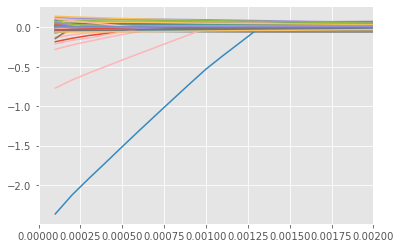

In [385]:
coefs_df = pd.DataFrame(np.array(coefs), columns = X_train_dum.columns)
for name in xxxx.columns:
    plt.plot(alphas, coefs_df[name])
plt.xlim(0, .002)

In [386]:
coefs_df

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0     -0.000275     0.000144  0.000001     0.045169     0.036395   0.001716   
1     -0.000236     0.000063  0.000001     0.048523     0.037716   0.001686   
2     -0.000234    -0.000017  0.000001     0.051229     0.039080   0.001664   
3     -0.000303    -0.000091  0.000001     0.053174     0.039868   0.001710   
4     -0.000370    -0.000170  0.000001     0.054931     0.040535   0.001741   
..          ...          ...       ...          ...          ...        ...   
96    -0.000804    -0.000737  0.000002     0.082088     0.034092   0.003195   
97    -0.000804    -0.000736  0.000002     0.082001     0.033995   0.003193   
98    -0.000804    -0.000734  0.000002     0.081913     0.033898   0.003192   
99    -0.000804    -0.000733  0.000002     0.081825     0.033801   0.003190   
100   -0.000805    -0.000732  0.000002     0.081737     0.033704   0.003189   

     YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0        0.001141    0.000023    0.000095    0.000096  ...            -0.0   
1        0.001118    0.000017    0.000085    0.000096  ...            -0.0   
2        0.001101    0.000012    0.000075    0.000090  ...            -0.0   
3        0.001088    0.000007    0.000065    0.000084  ...            -0.0   
4        0.001079    0.000004    0.000055    0.000078  ...            -0.0   
..            ...         ...         ...         ...  ...             ...   
96       0.001785   -0.000008    0.000072    0.000054  ...            -0.0   
97       0.001787   -0.000008    0.000072    0.000054  ...            -0.0   
98       0.001790   -0.000008    0.000072    0.000054  ...            -0.0   
99       0.001793   -0.000008    0.000072    0.000054  ...            -0.0   
100      0.001796   -0.000008    0.000072    0.000054  ...            -0.0   

     SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0             0.0      0.072425    -0.044355              -0.060610   
1             0.0      0.010521    -0.043795              -0.059796   
2             0.0      0.000000    -0.042668              -0.058812   
3             0.0      0.000000    -0.040137              -0.057564   
4             0.0      0.000000    -0.036420              -0.056466   
..            ...           ...          ...                    ...   
96            0.0      0.000000    -0.000000              -0.000000   
97            0.0      0.000000    -0.000000              -0.000000   
98            0.0      0.000000    -0.000000              -0.000000   
99            0.0      0.000000    -0.000000              -0.000000   
100           0.0      0.000000    -0.000000              -0.000000   

     SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0.0              0.112446             -0.032293   
1                      0.0              0.082492             -0.028472   
2                      0.0              0.060060             -0.022226   
3                      0.0              0.038052             -0.014651   
4                      0.0              0.015313             -0.006796   
..                     ...                   ...                   ...   
96                     0.0              0.000000             -0.000000   
97                     0.0              0.000000             -0.000000   
98                     0.0              0.000000             -0.000000   
99                     0.0              0.000000             -0.000000   
100                    0.0              0.000000             -0.000000   

     SaleCondition_Normal  SaleCondition_Partial  
0                     0.0                    0.0  
1                     0.0                    0.0  
2                     0.0                    0.0  
3                     0.0                    0.0  
4                    -0.0                    0.0  
..                    ...                    ...  
96                  

In [387]:
last_nonzero = []
for name in coefs_df.columns:
    nonzero_coef = coefs_df[name] > 0
    if nonzero_coef.sum() > 0:
        last = coefs_df[name][nonzero_coef].index[-1]
        last_nonzero.append(last)
    else:
        last = -1
    
sorted(list(zip(coefs_df.columns, last_nonzero)), key = lambda x: -x[1])

# 100 indicates that feature's coefficient has not yet reached 0.

# There is some overlap between these features and those obtained
# by examining gradient boosting feature importances.

[('LotFrontage', 100),
 ('LotArea', 100),
 ('OverallQual', 100),
 ('OverallCond', 100),
 ('YearBuilt', 100),
 ('MasVnrArea', 100),
 ('BsmtFinSF1', 100),
 ('BsmtFinSF2', 100),
 ('BsmtUnfSF', 100),
 ('TotalBsmtSF', 100),
 ('X1stFlrSF', 100),
 ('X2ndFlrSF', 100),
 ('LowQualFinSF', 100),
 ('BedroomAbvGr', 100),
 ('KitchenAbvGr', 100),
 ('Fireplaces', 100),
 ('GarageCars', 100),
 ('WoodDeckSF', 100),
 ('OpenPorchSF', 100),
 ('EnclosedPorch', 100),
 ('TotRmsAbvGrd', 93),
 ('GrLivArea', 91),
 ('LotConfig_Corner', 73),
 ('X3SsnPorch', 71),
 ('BldgType_1Fam', 69),
 ('BldgType_Duplex', 67),
 ('Condition1_RRNe', 66),
 ('Neighborhood_Sawyer', 60),
 ('Condition1_Norm', 45),
 ('LotShape_IR2', 44),
 ('Condition2_RRNn', 43),
 ('Neighborhood_SawyerW', 41),
 ('Neighborhood_StoneBr', 37),
 ('LandContour_Bnk', 34),
 ('Neighborhood_CollgCr', 34),
 ('Neighborhood_Veenker', 32),
 ('Condition2_Artery', 29),
 ('Condition2_PosA', 27),
 ('RoofStyle_Gable', 26),
 ('HalfBath', 25),
 ('Condition1_PosN', 25),
 ('MSZ

Scatterplots for important features in train set and in predictions for first elastic net regression

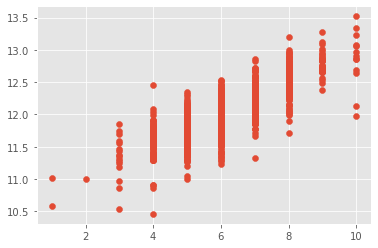

In [388]:
plt.scatter(X_train_dum['OverallQual'], y_train)

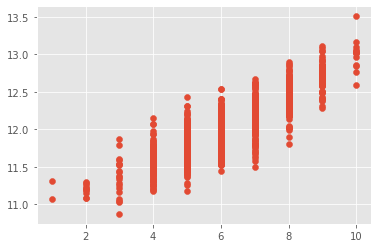

In [389]:
plt.scatter(test_data['OverallQual'], enet_best.predict(test_data))
# nearly same shape

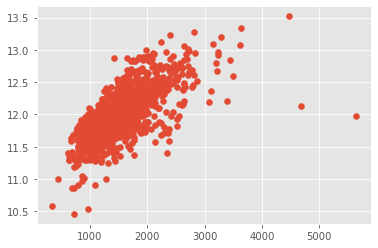

In [392]:
plt.scatter(X_train_dum['GrLivArea'], y_train)

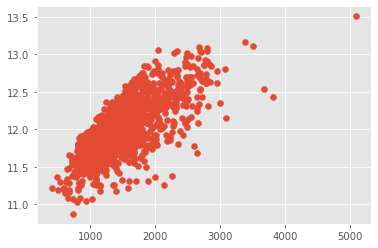

In [393]:
plt.scatter(test_data['GrLivArea'], enet_best.predict(test_data))
#Very similar again

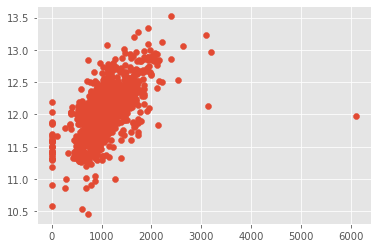

In [394]:
plt.scatter(X_train_dum['TotalBsmtSF'], y_train)

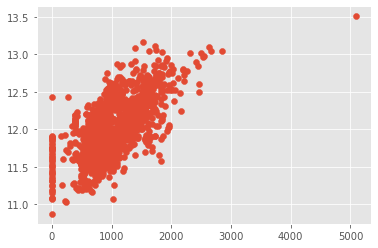

In [395]:
plt.scatter(test_data['TotalBsmtSF'], enet_best.predict(test_data))

#Again, quite consistent